# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Image is just an array of pixels where each pixel represents an entry an array and represents intensity at that position. Pixel intensity ranges generally from 0-255 where 0 represents black and 255 represents white and everything else grayscale values.

(Grayscale image is generally represented via 2D array whereas RGB Image is generally represented via 3D array)

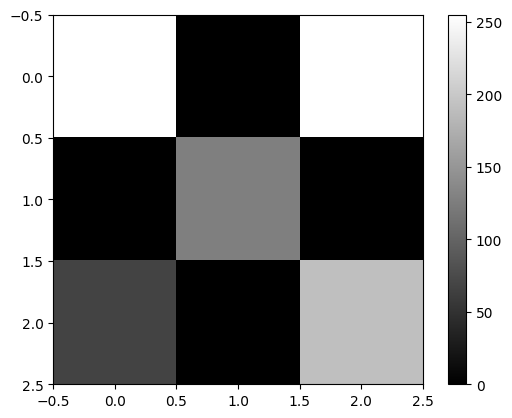

In [2]:
trial_img = np.array([[255, 0, 255], 
                      [0, 127, 0], 
                      [67, 0, 191]])
plt.imshow(trial_img, cmap = 'gray')
plt.colorbar();

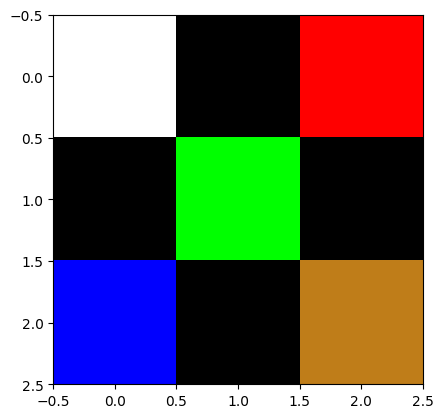

In [3]:
#In RGB each pixel intensity is array of 3 in
trial_img_rgb = np.array([[[255, 255, 255], 
                           [0, 0, 0], 
                           [255, 0, 0]], 
                          [[0, 0, 0], 
                           [0, 255, 0], 
                           [0, 0, 0]], 
                          [[0, 0, 255], 
                           [0, 0, 0], 
                           [191, 125, 25]]])
plt.imshow(trial_img_rgb)

Before neural network, in traditional setting, feature extraction has to be carried out where features of images are extracted (like histogram processing, edge/corner detection, finding image gradient, etc.). The technique to be used is generally dependent on the task at hand which could be quite cumbersome.

Neural Networks removes this steps since it acts as a feature extractor in itself and how to use these feature to get the desired result.

# Building Artificial Neural Network (Very Basic)

## Hyperparameters

In [4]:
batch_size = 64
learning_rate = 1e-3
epochs = 150

## Downloading and preprocessing data

In [5]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
fashion_mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [6]:
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
print(f"Number of Training Images: {len(train_images)}")
print(train_images.shape, train_labels.shape)

Number of Training Images: 60000
torch.Size([60000, 28, 28]) torch.Size([60000])


In [7]:
print(f"Classes present in dataset: \n{fashion_mnist_train.classes}")

Classes present in dataset: 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


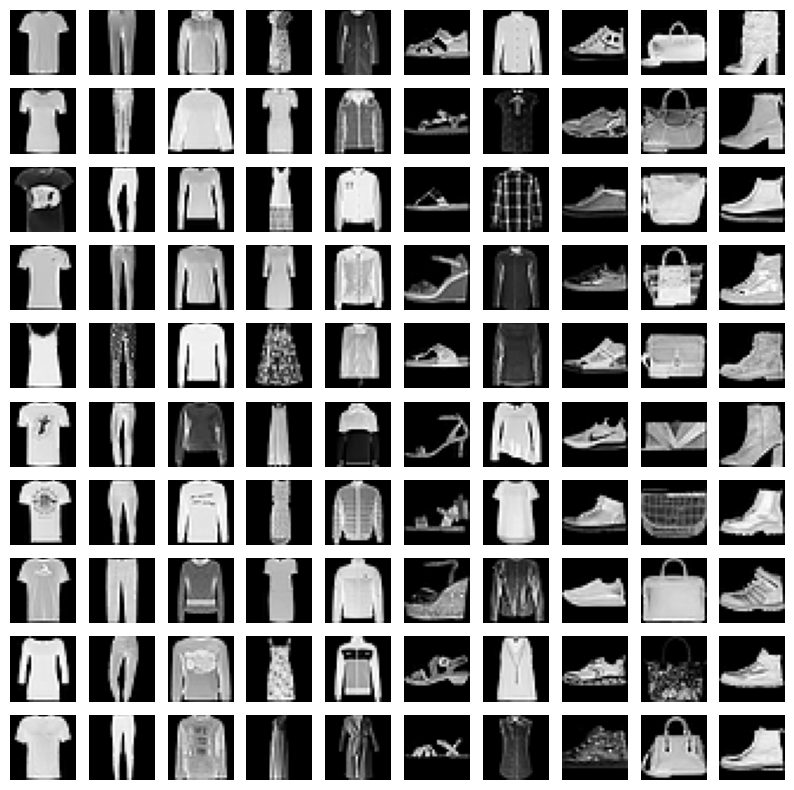

In [8]:
# Visualizing Data
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

In [9]:
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
fashion_mnist_valid

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [10]:
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets
print(f"Number of Valid Images: {len(valid_images)}")
print(valid_images.shape, valid_labels.shape)

Number of Valid Images: 10000
torch.Size([10000, 28, 28]) torch.Size([10000])


## Helper functions for training

In [11]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Flattening 2D image into a vector
        img = img.view(-1)
        return img, lbl

In [12]:
def get_data(bs = 64):
    train_data = FMNISTDataset(train_images, train_labels)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True)
    valid_data = FMNISTDataset(valid_images, valid_labels)
    validloader = DataLoader(valid_data, batch_size = bs)
    return trainloader, validloader

def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr)
    return model, criterion, optimizer

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

## Training

In [13]:
trainloader, validloader = get_data(batch_size)
model, criterion, optimizer = build_model(learning_rate)
train_accuracies, valid_accuracies = [], []
train_losses, valid_losses = [], []
for epoch in range(epochs):
    print(f"{'*'*10} EPOCH {epoch:2}/{epochs-1} {'*'*10}")
    batch_loss = 0.0
    model.train()
    for imgs, lbls in trainloader:
        batch_loss += train_batch(imgs, lbls, model, criterion, optimizer)
    
    total_correct = 0
    total = 0
    for imgs, lbls in trainloader:
        batch_correct, batch_total = no_of_correct(imgs, lbls, model)
        total_correct += batch_correct
        total += batch_total
        
    epoch_train_acc = total_correct/total
    train_accuracies.append(epoch_train_acc)
    epoch_train_loss = batch_loss / len(trainloader)
    train_losses.append(epoch_train_loss)
    
    # Calculating for Valid data
    batch_loss = 0.0
    total_correct = 0
    total = 0
    for imgs, lbls in validloader:
        batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
        batch_correct, batch_total = no_of_correct(imgs, lbls, model)
        total_correct += batch_correct
        total += batch_total
        
    epoch_valid_loss = batch_loss / len(validloader)
    epoch_valid_acc = total_correct / total
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_acc)
    
    print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')

********** EPOCH  0/149 **********
#################################
Train Loss: 1.970, Train Accuracy: 65.30
Valid Loss: 1.679, Valid Accuracy: 64.27
#################################
********** EPOCH  1/149 **********
#################################
Train Loss: 1.452, Train Accuracy: 66.43
Valid Loss: 1.278, Valid Accuracy: 65.71
#################################
********** EPOCH  2/149 **********
#################################
Train Loss: 1.156, Train Accuracy: 67.54
Valid Loss: 1.072, Valid Accuracy: 66.39
#################################
********** EPOCH  3/149 **********
#################################
Train Loss: 1.000, Train Accuracy: 69.57
Valid Loss: 0.957, Valid Accuracy: 68.28
#################################
********** EPOCH  4/149 **********
#################################
Train Loss: 0.907, Train Accuracy: 71.07
Valid Loss: 0.884, Valid Accuracy: 69.63
#################################
********** EPOCH  5/149 **********
#################################
Train 

#################################
Train Loss: 0.478, Train Accuracy: 83.82
Valid Loss: 0.504, Valid Accuracy: 82.72
#################################
********** EPOCH 46/149 **********
#################################
Train Loss: 0.476, Train Accuracy: 83.86
Valid Loss: 0.502, Valid Accuracy: 82.69
#################################
********** EPOCH 47/149 **********
#################################
Train Loss: 0.474, Train Accuracy: 83.92
Valid Loss: 0.501, Valid Accuracy: 82.71
#################################
********** EPOCH 48/149 **********
#################################
Train Loss: 0.472, Train Accuracy: 83.94
Valid Loss: 0.499, Valid Accuracy: 82.69
#################################
********** EPOCH 49/149 **********
#################################
Train Loss: 0.470, Train Accuracy: 84.00
Valid Loss: 0.497, Valid Accuracy: 82.81
#################################
********** EPOCH 50/149 **********
#################################
Train Loss: 0.468, Train Accuracy: 84.05


#################################
Train Loss: 0.422, Train Accuracy: 85.54
Valid Loss: 0.456, Valid Accuracy: 84.00
#################################
********** EPOCH 91/149 **********
#################################
Train Loss: 0.422, Train Accuracy: 85.54
Valid Loss: 0.454, Valid Accuracy: 84.07
#################################
********** EPOCH 92/149 **********
#################################
Train Loss: 0.421, Train Accuracy: 85.52
Valid Loss: 0.454, Valid Accuracy: 83.93
#################################
********** EPOCH 93/149 **********
#################################
Train Loss: 0.420, Train Accuracy: 85.57
Valid Loss: 0.454, Valid Accuracy: 84.13
#################################
********** EPOCH 94/149 **********
#################################
Train Loss: 0.419, Train Accuracy: 85.65
Valid Loss: 0.454, Valid Accuracy: 83.82
#################################
********** EPOCH 95/149 **********
#################################
Train Loss: 0.418, Train Accuracy: 85.64


#################################
Train Loss: 0.393, Train Accuracy: 86.50
Valid Loss: 0.430, Valid Accuracy: 84.65
#################################
********** EPOCH 136/149 **********
#################################
Train Loss: 0.392, Train Accuracy: 86.58
Valid Loss: 0.431, Valid Accuracy: 84.84
#################################
********** EPOCH 137/149 **********
#################################
Train Loss: 0.392, Train Accuracy: 86.57
Valid Loss: 0.429, Valid Accuracy: 84.78
#################################
********** EPOCH 138/149 **********
#################################
Train Loss: 0.391, Train Accuracy: 86.64
Valid Loss: 0.429, Valid Accuracy: 84.75
#################################
********** EPOCH 139/149 **********
#################################
Train Loss: 0.391, Train Accuracy: 86.59
Valid Loss: 0.429, Valid Accuracy: 84.82
#################################
********** EPOCH 140/149 **********
#################################
Train Loss: 0.390, Train Accuracy: 8

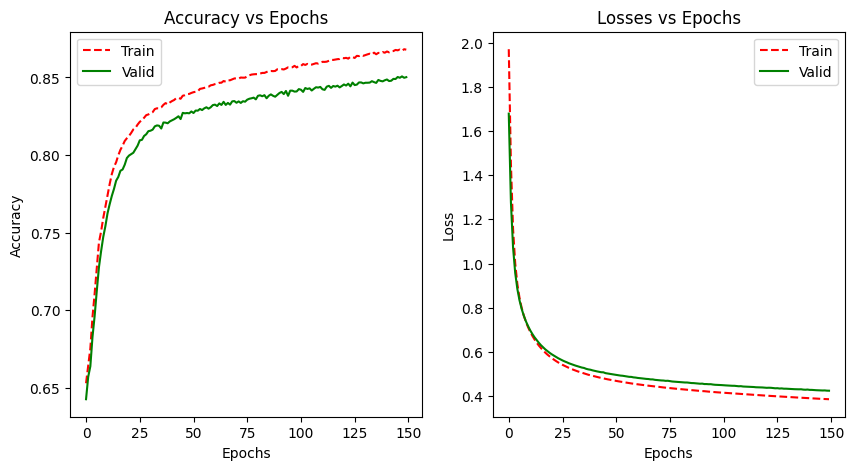

In [14]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

NOTE: Accuracy and loss of valid dataset starts to flatten out whereas of train dataset it is improving resulting in overfitting, now tuning hyperparams to check for any  improvement in the performance